In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from scipy import stats

from tess_backml import BackgroundCube

from scipy.interpolate import RectBivariateSpline
from tqdm import tqdm

In [2]:
sector = 2
camera = 2
ccd = 4

In [3]:
cube_data = np.load(f"./data/ffi_cube_bin16_sector{sector:03}_{camera}-{ccd}.npz")
cube_data.items()

ItemsView(NpzFile './data/ffi_cube_bin16_sector002_2-4.npz' with keys: scatter_cube, time, cadenceno)

In [4]:
cube_time = cube_data["time"]
cube_cadenceno = cube_data["cadenceno"]
cube_sl = cube_data["scatter_cube"]

In [5]:
cube_sl.shape, cube_time.shape

((1245, 128, 128), (1245,))

In [6]:
cube_sl.min(), cube_sl.max()

(-0.7767868, 1942.6877)

In [7]:
rmin, rmax = 0, 2048
cmin, cmax = 45, 2093

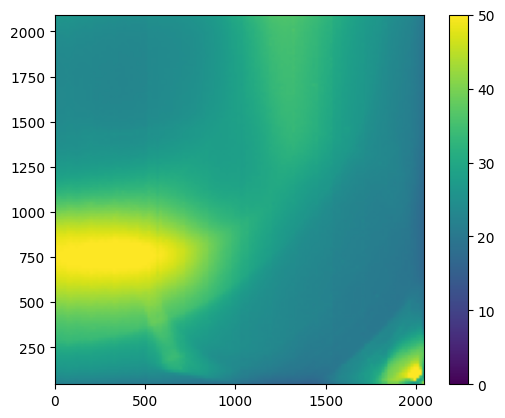

In [8]:
bar = plt.imshow(cube_sl[1172], origin="lower", vmin=0, vmax=50, extent=(rmin, rmax, cmin, cmax))
plt.colorbar(bar)
plt.show()

In [9]:
step = 16
row, col = np.mgrid[rmin:rmax:step, cmin:cmax:step]
row

array([[   0,    0,    0, ...,    0,    0,    0],
       [  16,   16,   16, ...,   16,   16,   16],
       [  32,   32,   32, ...,   32,   32,   32],
       ...,
       [2000, 2000, 2000, ..., 2000, 2000, 2000],
       [2016, 2016, 2016, ..., 2016, 2016, 2016],
       [2032, 2032, 2032, ..., 2032, 2032, 2032]])

In [11]:
# %%timeit
tdx = 1172
interp2d = RectBivariateSpline(col[0, :], row[:, 0], cube_sl[tdx])

eval_row = np.arange(rmin, rmax)
eval_col = np.arange(cmin, cmax)

eval_sl = interp2d(eval_col, eval_row)
eval_sl

array([[22.21590424, 22.18914168, 22.16430991, ..., 41.33068848,
        41.33068848, 41.33068848],
       [22.32054688, 22.29286837, 22.26721537, ..., 40.7612772 ,
        40.7612772 , 40.7612772 ],
       [22.42216737, 22.3934432 , 22.36685892, ..., 40.19513493,
        40.19513493, 40.19513493],
       ...,
       [27.086483  , 27.04214385, 27.00123126, ..., 19.95185852,
        19.95185852, 19.95185852],
       [27.086483  , 27.04214385, 27.00123126, ..., 19.95185852,
        19.95185852, 19.95185852],
       [27.086483  , 27.04214385, 27.00123126, ..., 19.95185852,
        19.95185852, 19.95185852]])

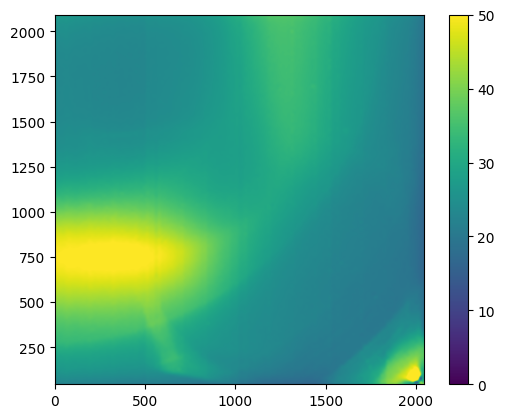

In [12]:
bar = plt.imshow(eval_sl, origin="lower", vmin=0, vmax=50, 
           extent=(eval_row.min(), eval_row.max(), eval_col.min(), eval_col.max()))
plt.colorbar(bar)
plt.show()

## Inspect Resdiuals after upscaling

In [13]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

In [16]:
bkgcube = BackgroundCube(
    sector=sector, camera=camera, ccd=ccd, img_bin=16, downsize="binning"
)
print(bkgcube)

TESS FFI Background object (Sector, Camera, CCD, N times): 2, 2, 4, 1245


In [17]:
bkgcube._get_dark_frame_idx()
bkgcube._get_star_mask(sigma=5.0, dilat_iter=2)
bkgcube._get_straps_mask()
static = bkgcube._get_static_scene()

Computing average static scene from darkes frames...


100%|██████████| 125/125 [03:28<00:00,  1.67s/it]


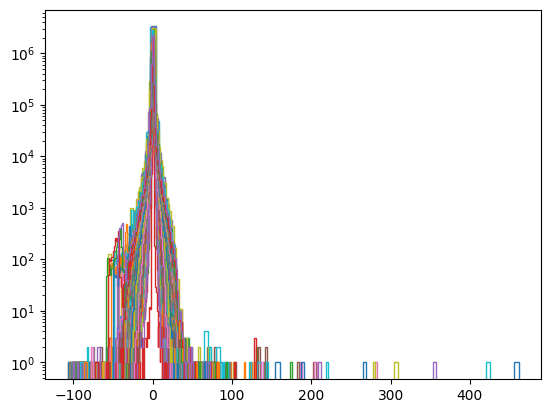

In [18]:
metrics = pd.DataFrame(columns=["mean", "std", "median", "mad", "rchi2", "skew", "kurtosis"])

step = 16
row = np.arange(rmin, rmax, step)
col = np.arange(cmin, cmax, step)
eval_row = np.arange(rmin, rmax)
eval_col = np.arange(cmin, cmax)

bkgcube.bkg_pixels = ~bkgcube.star_mask
bkgcube.bkg_pixels &= ~bkgcube.strap_mask
mask_pixels = ~bkgcube.bkg_pixels

for tdx in tqdm(range(0, cube_sl.shape[0], 10)):

    interp2d = RectBivariateSpline(col, row, cube_sl[tdx])
    eval_sl = interp2d(eval_col, eval_row)
    
    raw = bkgcube.tcube.get_ffi(tdx)[1].data[
        bkgcube.rmin : bkgcube.rmax, bkgcube.cmin : bkgcube.cmax
    ]
    raw[mask_pixels] = np.nan
    current = raw - static

    metrics.loc[tdx, "mean"] = np.nanmean((current - eval_sl).ravel())
    metrics.loc[tdx, "std"] = np.nanstd((current - eval_sl).ravel())
    metrics.loc[tdx, "median"] = np.nanmedian((current - eval_sl).ravel())
    metrics.loc[tdx, "mad"] = stats.median_abs_deviation((current - eval_sl).ravel(), center=np.nanmedian, nan_policy="omit")

    zero_mask = current != 0
    metrics.loc[tdx, "rchi2"] = np.nansum((eval_sl[zero_mask] - current[zero_mask])** 2 / np.sqrt(current[zero_mask])) / np.multiply(*current.shape)
    metrics.loc[tdx, "skew"] = stats.skew((current - eval_sl).ravel(), nan_policy="omit")
    metrics.loc[tdx, "kurtosis"] = stats.kurtosis((current - eval_sl).ravel(), nan_policy="omit")

    plt.hist((current - eval_sl).ravel(), bins=100, log=True, histtype="step", lw=10)

    # break
plt.show()

In [19]:
metrics

mean       std    median       mad     rchi2       skew     kurtosis
0    -0.004318  0.471162 -0.005285   0.23546  0.137536  -4.339871   904.157801
10   -0.002609  0.497969 -0.004492  0.239565  0.143628  -1.183544   285.861306
20   -0.002102  0.426693 -0.003429  0.229524   0.12209  24.014389   8655.52739
30   -0.002077  0.407091  -0.00349  0.230295  0.120098  -8.807118  1825.264937
40   -0.002653  0.439897 -0.003317  0.235938  0.128321  -2.426136   482.202032
...        ...       ...       ...       ...       ...        ...          ...
1200 -0.049557   1.95037 -0.033093  0.407874  1.646172  -3.972562   112.924923
1210 -0.080254  1.999179 -0.059937  0.424359   1.90365    -4.6293   125.984259
1220 -0.143701  2.086602 -0.105178  0.455549  2.574722  -6.484486   167.761753
1230 -0.214375  2.158092  -0.14969  0.487261  3.296795  -6.104115   158.605995
1240 -0.213563  2.112026 -0.145522  0.509808  2.462011  -4.133095    109.54964

[125 rows x 7 columns]

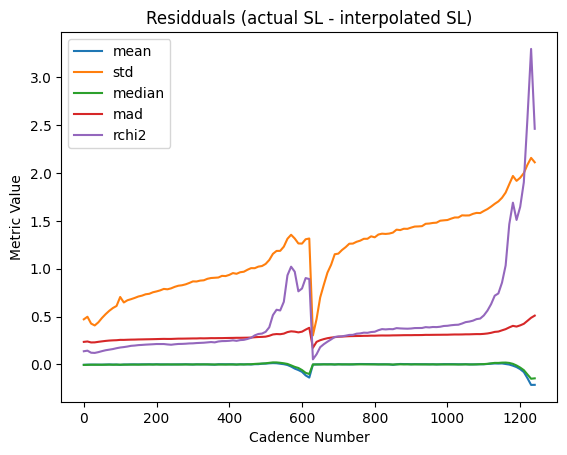

In [22]:
ax = metrics.loc[:, ["mean", "std", "median", "mad", "rchi2"]].plot()
ax.set_xlabel("Cadence Number")
ax.set_ylabel("Metric Value")
ax.set_title("Residduals (actual SL - interpolated SL)")
plt.show()

## Correct Scatter Light in FFI light curves

TOIs in this Sector/Camera/CCD

| TIC       | Camera | CCD | TOI Disposition | RA | Dec | TMag |
|-----------|--------|-----|-----------------|----|-----|------|
| 144440290 | 2 | 4 |	EB | 359.161519 | -44.719088 | 8.723  |
| 183537452 | 2 | 4 |	KP | 357.879533 | -39.906726 | 10.195 |
| 183985250 | 2 | 4 |	CP | 358.667547 | -37.628020 | 9.098  |
| 184240683 | 2 | 4 |	KP | 359.348992 | -41.277150 | 11.502 |
| 224225541 | 2 | 4 |	CP | 353.061818 | -37.255890 | 9.307  |
| 402026209 | 2 | 4 |	KP | 353.562839 | -42.061409 | 11.778 |


In [266]:
from tesscube import TESSCube
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from scipy import ndimage

In [282]:
tois = pd.DataFrame(
    [
        [144440290, 2, 4, "EB", 359.161519, -44.719088, 8.723],
        [183537452, 2, 4, "KP", 357.879533, -39.906726, 10.195],
        [183985250, 2, 4, "CP", 358.667547, -37.628020, 9.098],
        [184240683, 2, 4, "KP", 359.348992, -41.277150, 11.502],
        [224225541, 2, 4, "CP", 353.061818, -37.255890, 9.307],
        [402026209, 2, 4, "KP", 353.562839, -42.061409, 11.778,]
    ],
    columns=["TIC", "camera", "ccd", "disposition","ra", "dec","tmag"]
)
tois

TIC  camera  ccd disposition          ra        dec    tmag
0  144440290       2    4          EB  359.161519 -44.719088   8.723
1  183537452       2    4          KP  357.879533 -39.906726  10.195
2  183985250       2    4          CP  358.667547 -37.628020   9.098
3  184240683       2    4          KP  359.348992 -41.277150  11.502
4  224225541       2    4          CP  353.061818 -37.255890   9.307
5  402026209       2    4          KP  353.562839 -42.061409  11.778

In [315]:
tics = pd.read_csv(f"./data/all_targets_S{sector:03}_v1.csv", skiprows=5).query(f"Camera == {camera} and CCD == {ccd}")
tics = tics.rename(columns={"TICID":"TIC", "RA": "ra", "Dec": "dec"})
tics

TIC  Camera  CCD   Tmag        ra      dec
126      7129031       2    4   9.86    3.9531 -44.1077
127      7129680       2    4  10.51    4.1044 -43.3082
128      7129726       2    4   9.08    4.2241 -43.5406
129      7129788       2    4   8.66    4.1466 -43.8581
134      7144448       2    4   8.19    4.3010 -44.3644
...          ...     ...  ...    ...       ...      ...
15575  425864422       2    4   8.16  352.1221 -44.5869
15576  425864448       2    4   8.12  352.0632 -44.4626
15577  425864469       2    4  10.63  352.0835 -44.3856
15920  469914888       2    4   9.87  350.4189 -49.0417
15979  471013556       2    4  15.81  358.0342 -36.1778

[770 rows x 6 columns]

In [316]:
tcube = TESSCube(sector=sector, camera=camera, ccd=ccd)

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


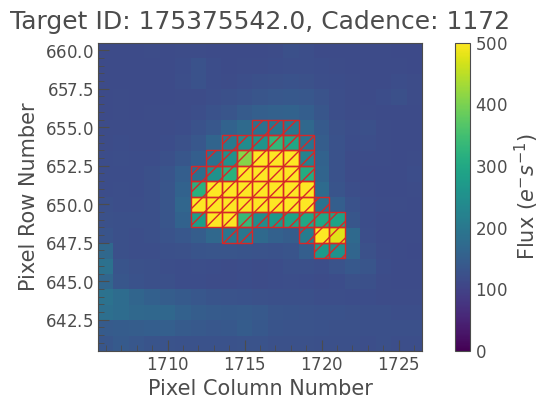

100%|██████████| 1245/1245 [00:01<00:00, 1059.71it/s]


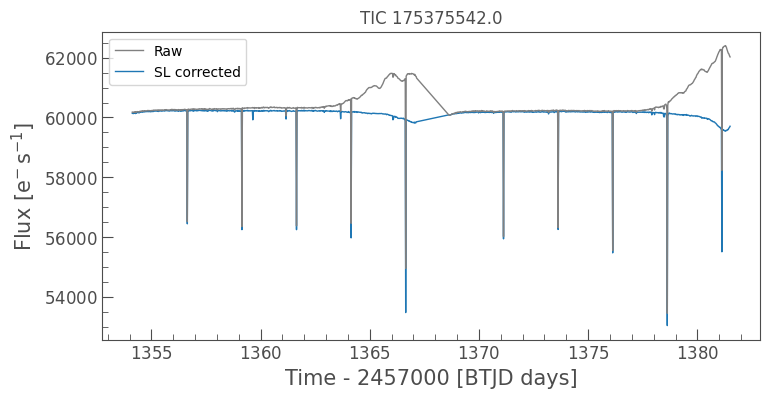

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


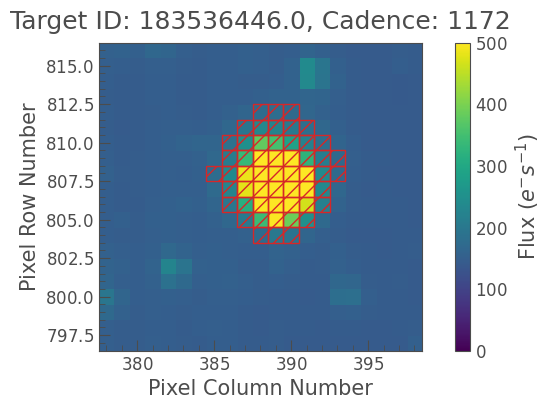

100%|██████████| 1245/1245 [00:01<00:00, 1079.21it/s]


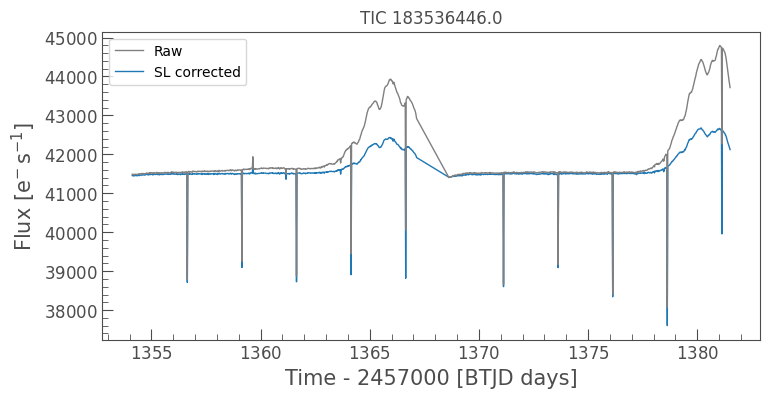

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


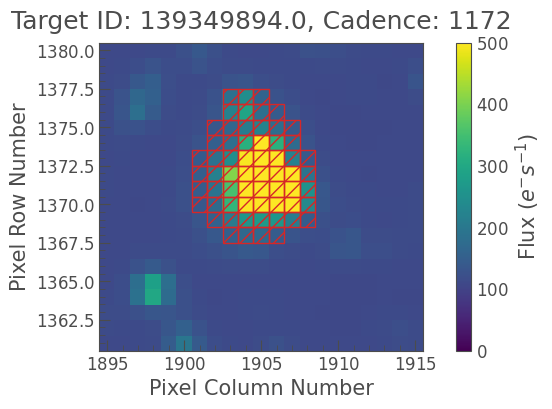

100%|██████████| 1245/1245 [00:01<00:00, 1054.54it/s]


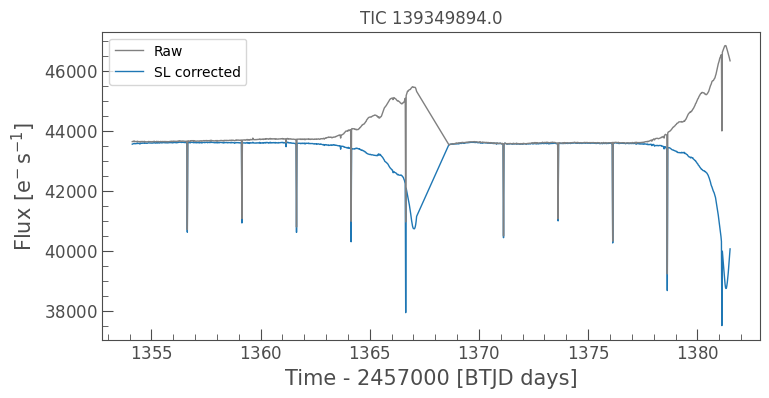

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


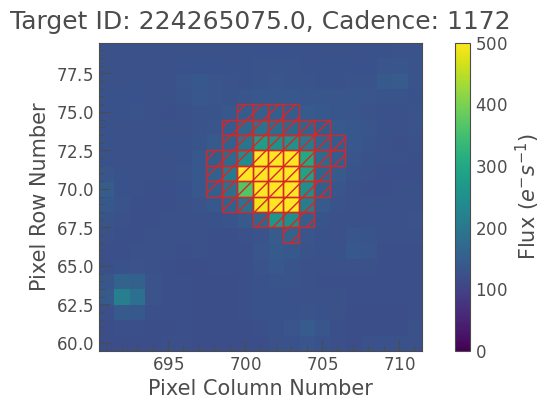

100%|██████████| 1245/1245 [00:01<00:00, 1077.35it/s]


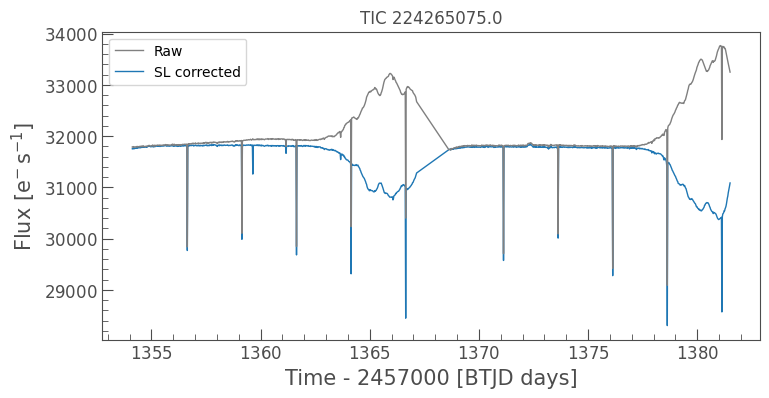

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


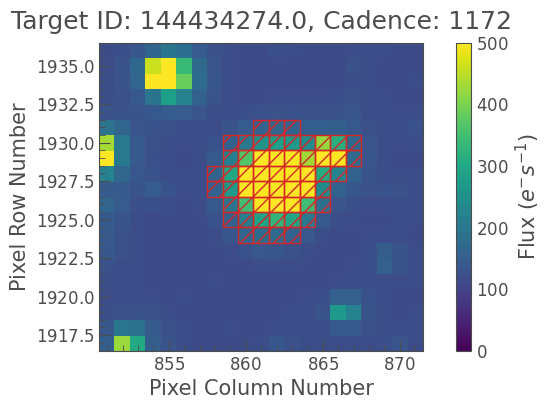

100%|██████████| 1245/1245 [00:01<00:00, 1081.60it/s]


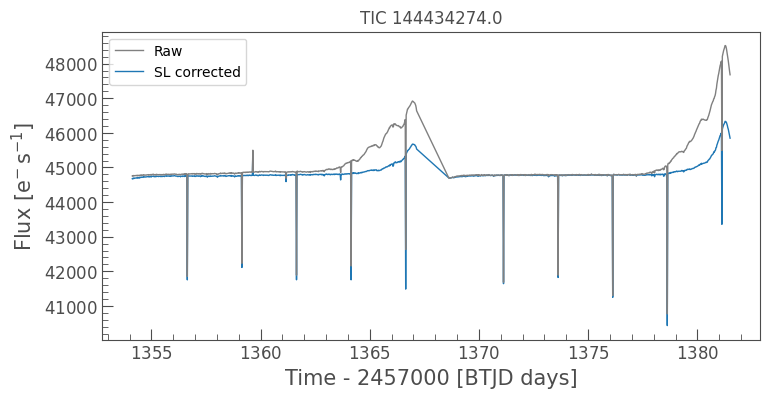

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


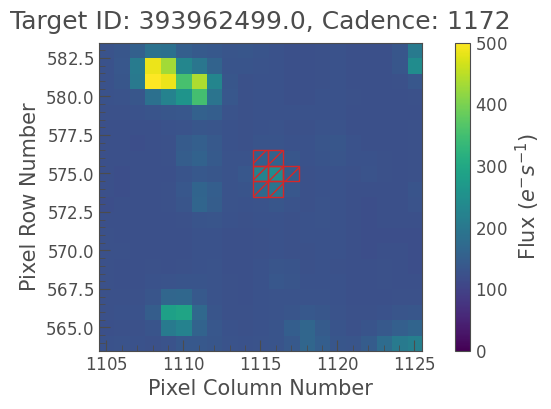

100%|██████████| 1245/1245 [00:01<00:00, 1067.53it/s]


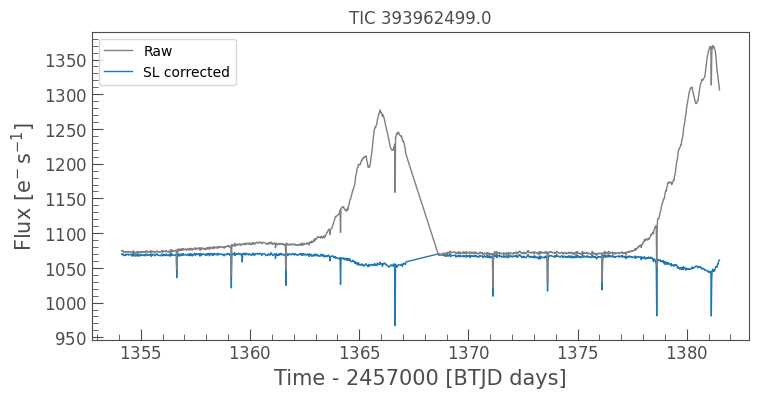

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


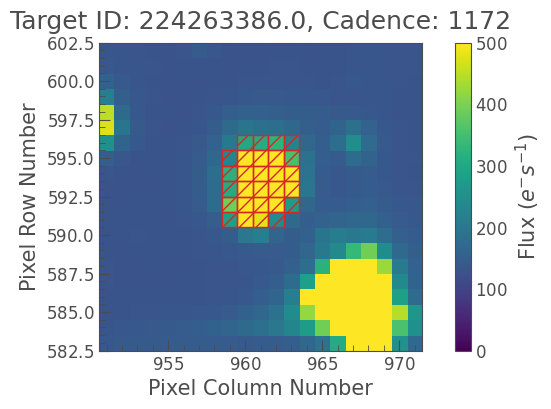

100%|██████████| 1245/1245 [00:01<00:00, 1061.60it/s]


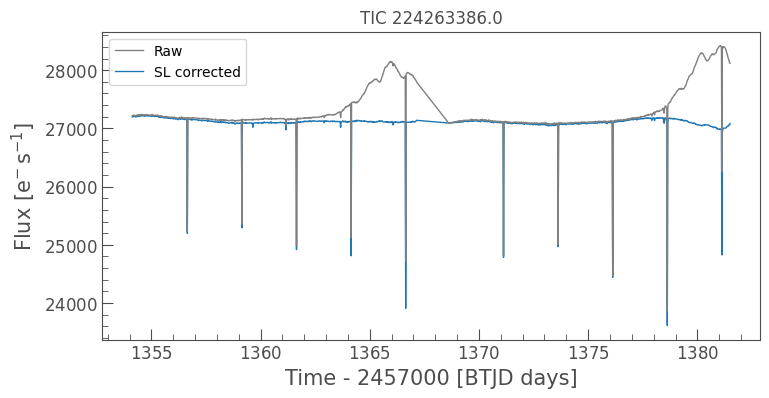

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


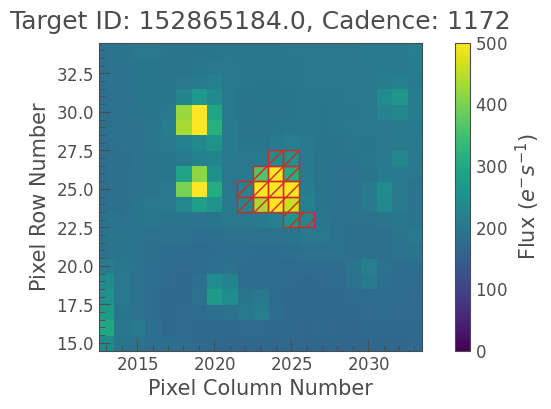

100%|██████████| 1245/1245 [00:01<00:00, 1083.89it/s]


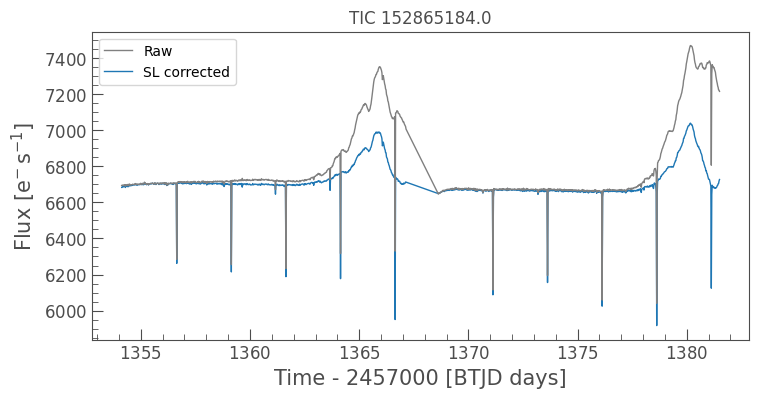

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


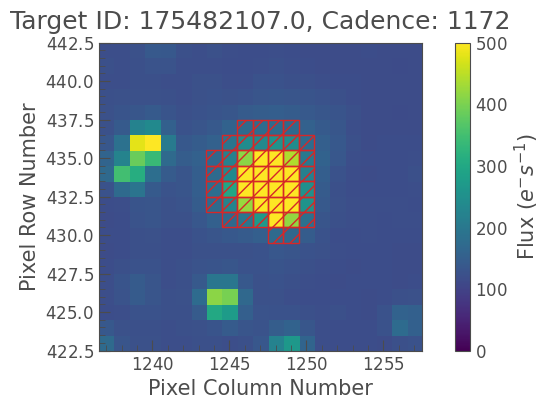

100%|██████████| 1245/1245 [00:01<00:00, 1055.72it/s]


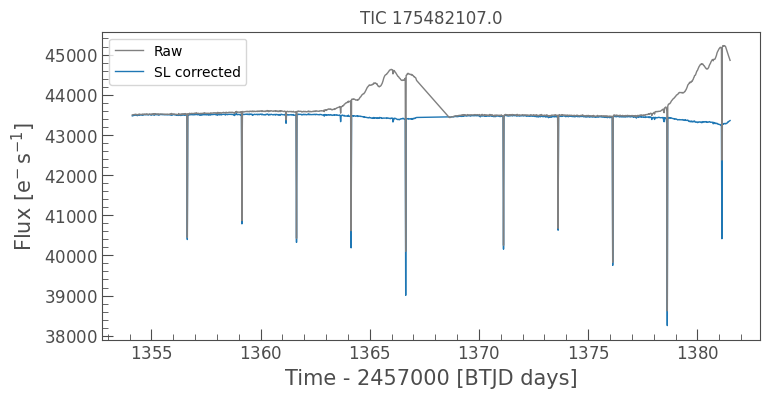

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


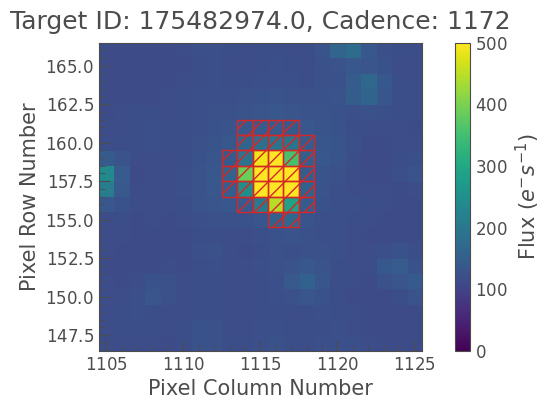

100%|██████████| 1245/1245 [00:01<00:00, 982.85it/s] 


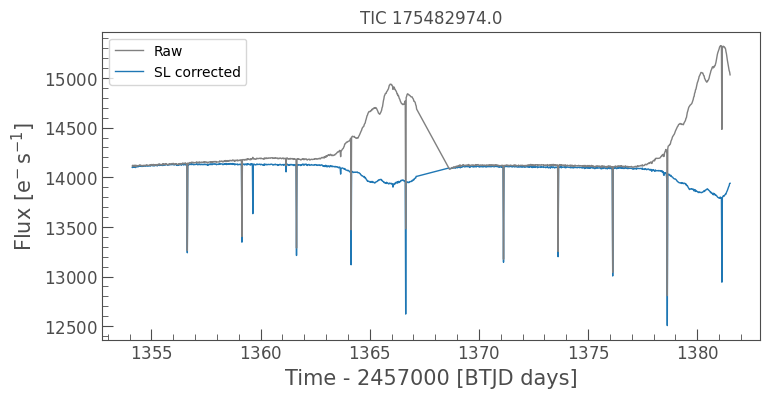

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


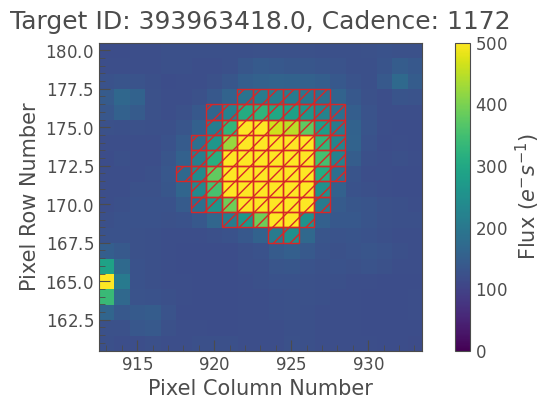

100%|██████████| 1245/1245 [00:01<00:00, 1068.04it/s]


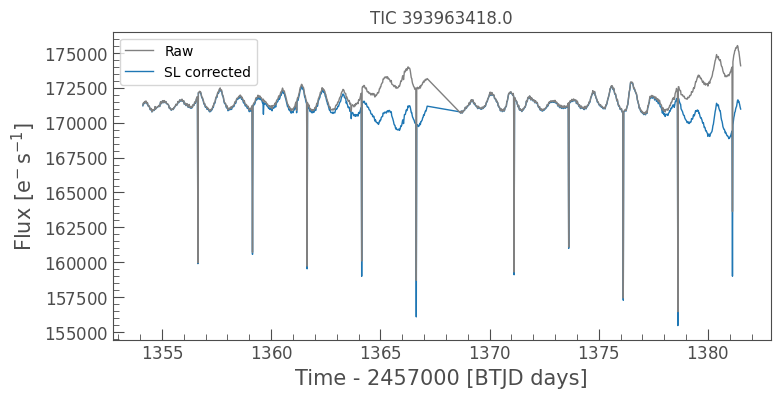

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


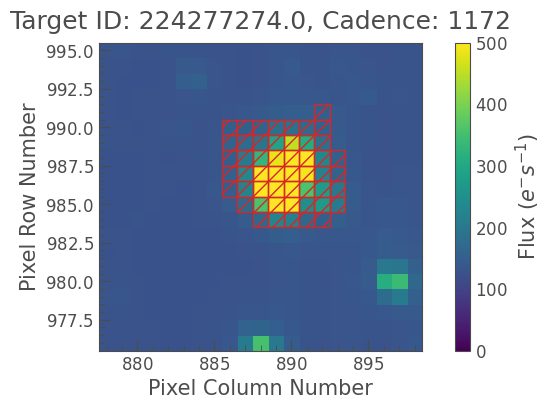

100%|██████████| 1245/1245 [00:01<00:00, 1069.58it/s]


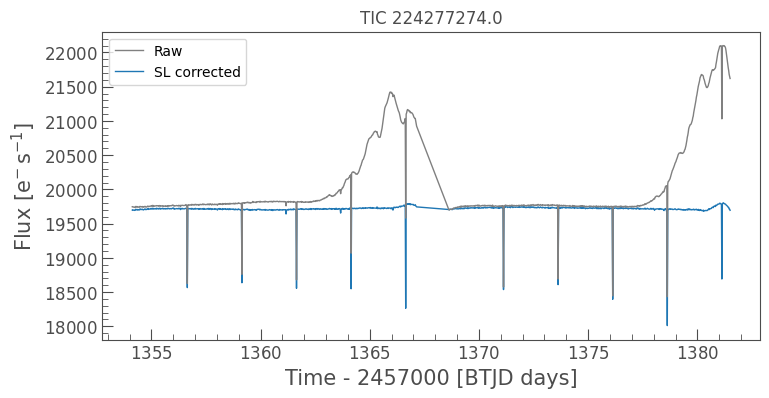

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


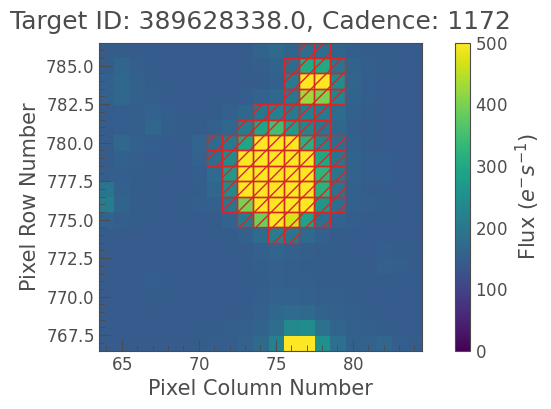

100%|██████████| 1245/1245 [00:01<00:00, 1086.56it/s]


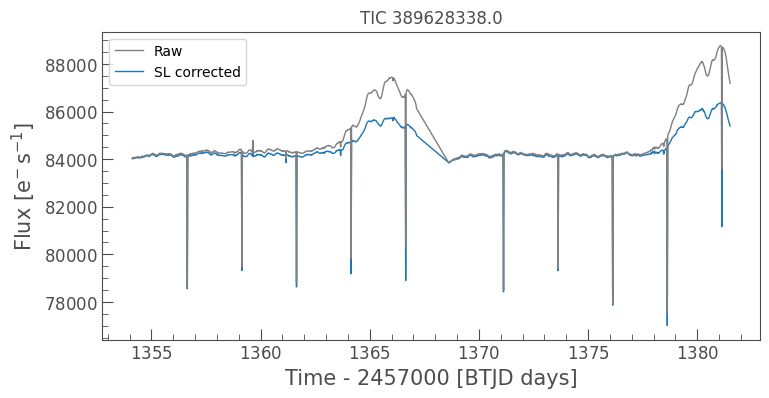

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


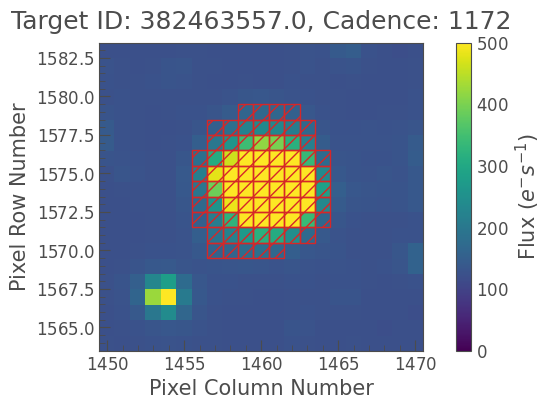

100%|██████████| 1245/1245 [00:01<00:00, 1086.47it/s]


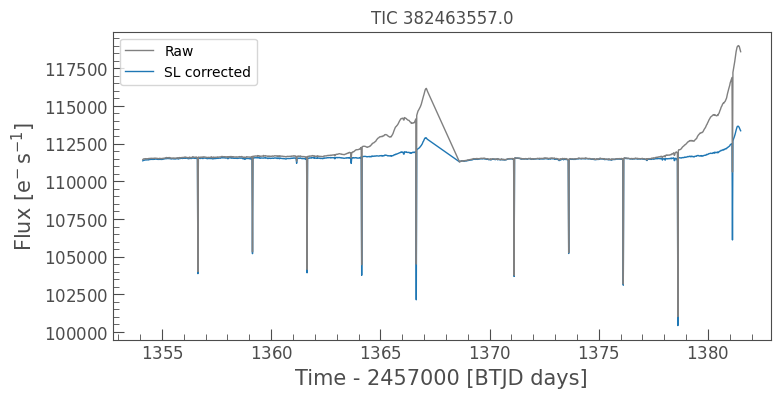

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


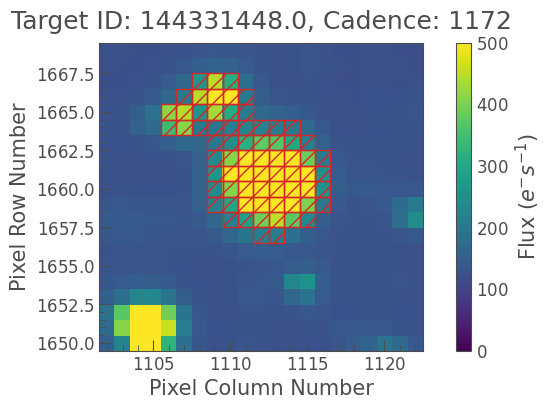

100%|██████████| 1245/1245 [00:01<00:00, 1038.96it/s]


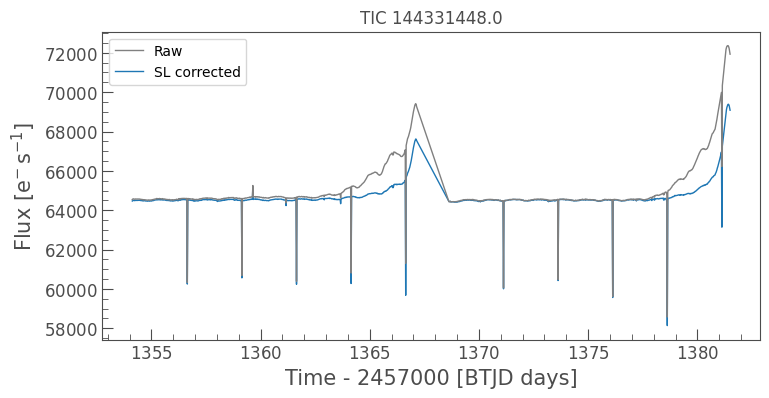

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


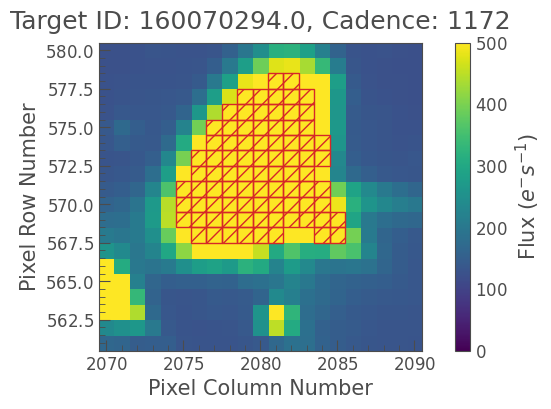

100%|██████████| 1245/1245 [00:01<00:00, 1060.71it/s]


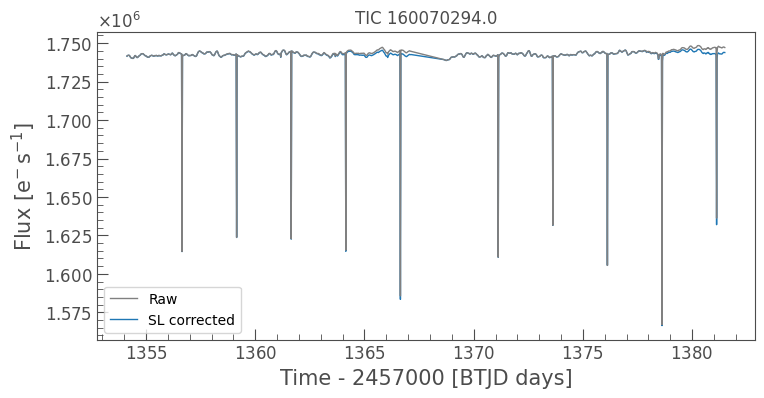

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


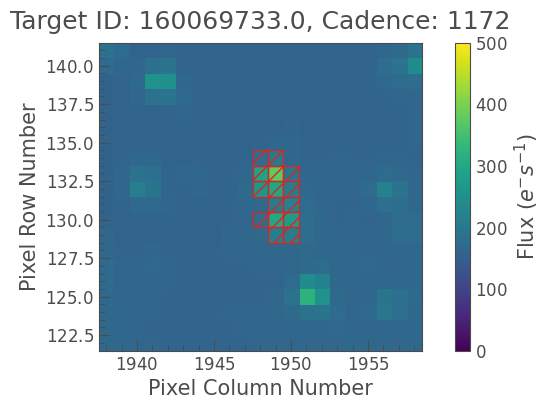

100%|██████████| 1245/1245 [00:01<00:00, 1076.48it/s]


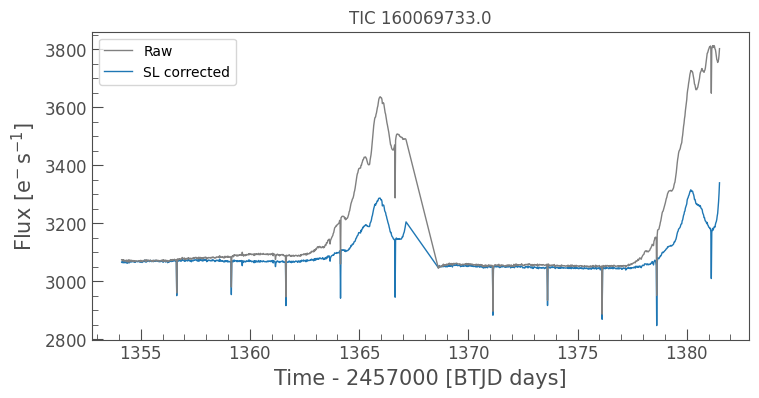

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


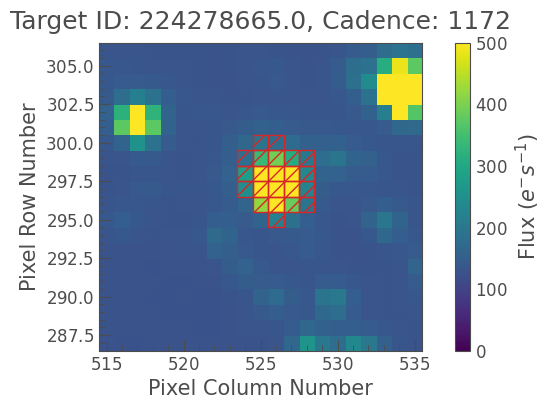

100%|██████████| 1245/1245 [00:01<00:00, 1057.45it/s]


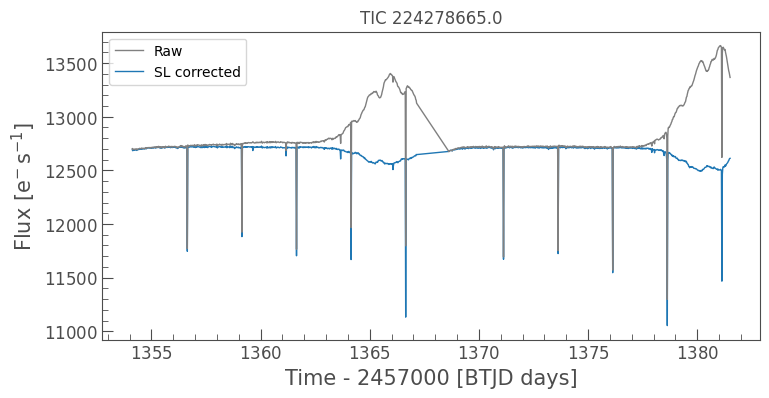

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


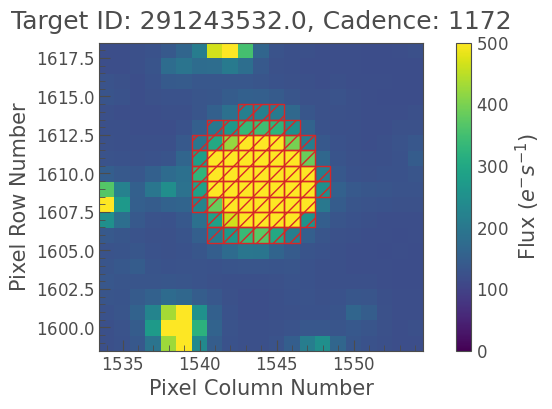

100%|██████████| 1245/1245 [00:01<00:00, 1085.55it/s]


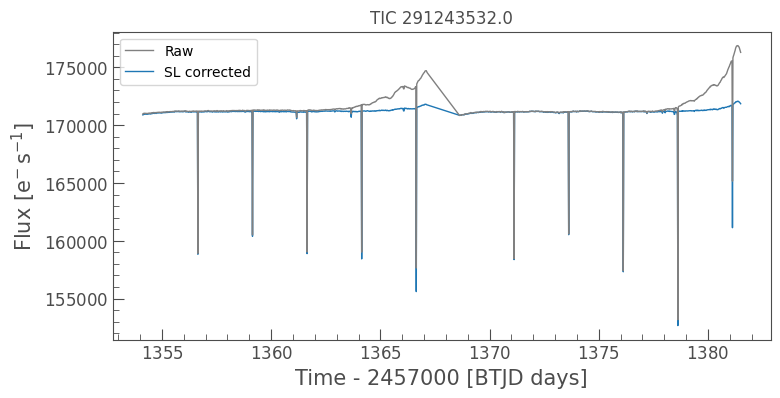

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


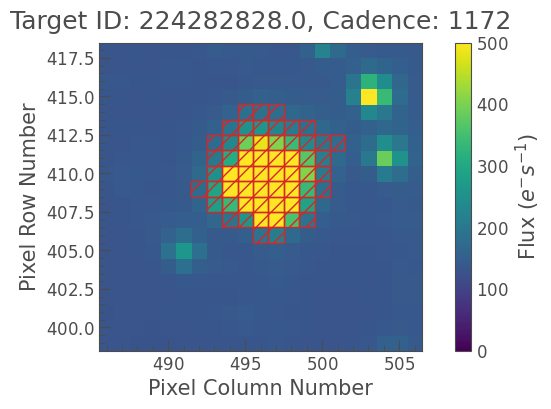

100%|██████████| 1245/1245 [00:01<00:00, 1075.25it/s]


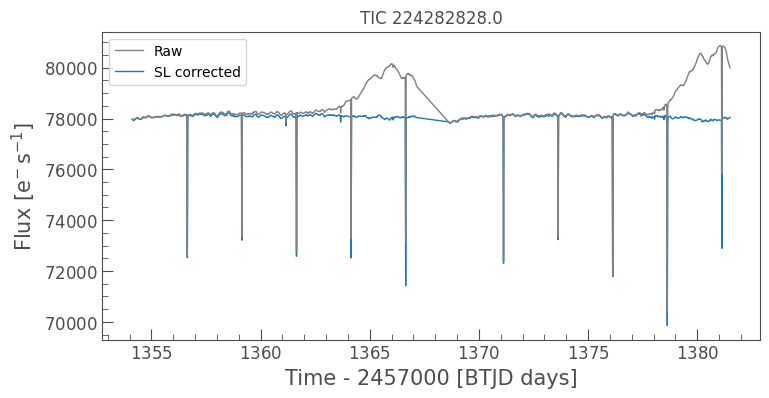

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


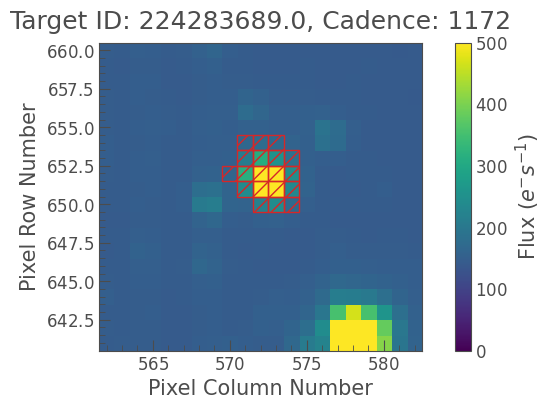

100%|██████████| 1245/1245 [00:01<00:00, 1079.64it/s]


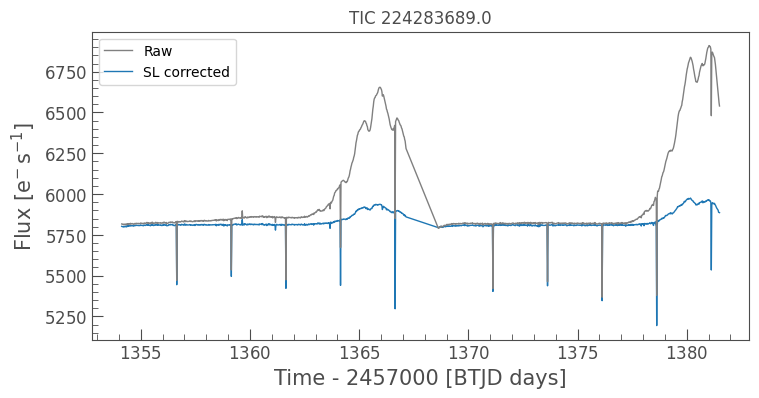

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


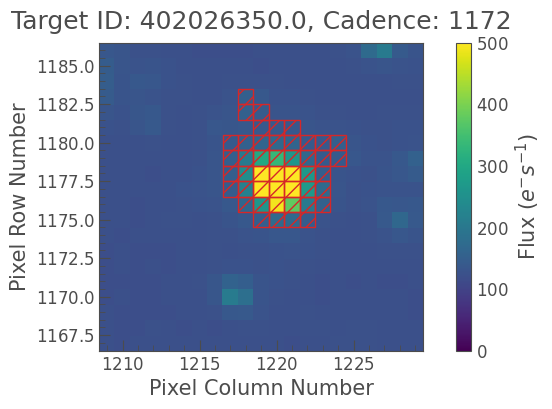

100%|██████████| 1245/1245 [00:01<00:00, 1089.02it/s]


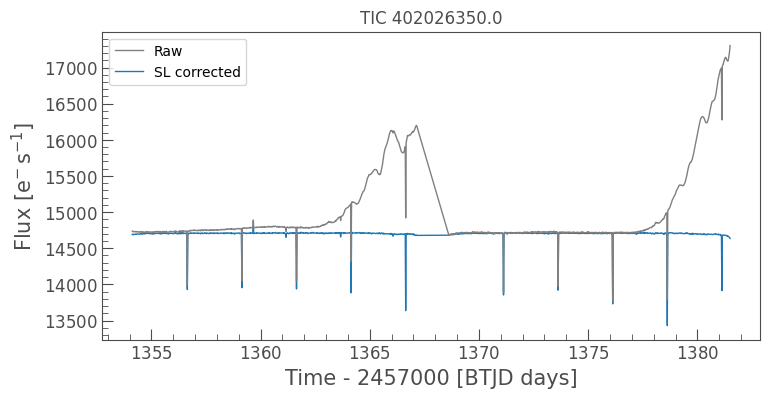

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


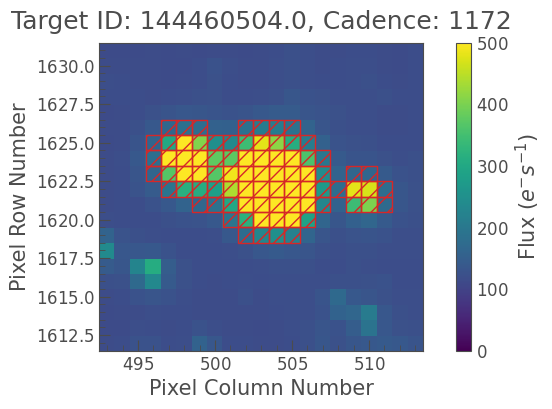

100%|██████████| 1245/1245 [00:01<00:00, 1096.50it/s]


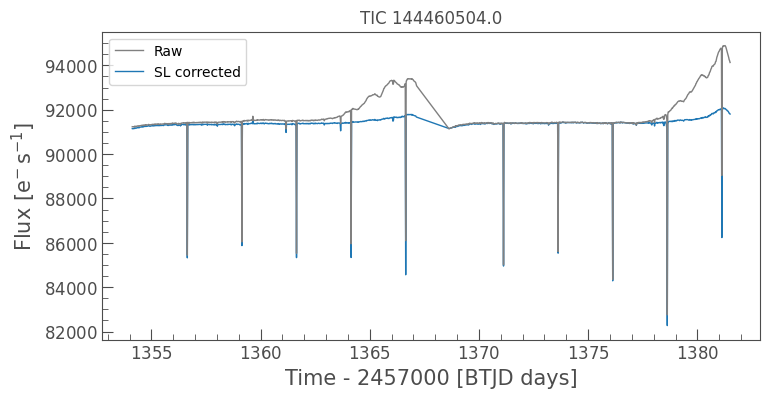

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


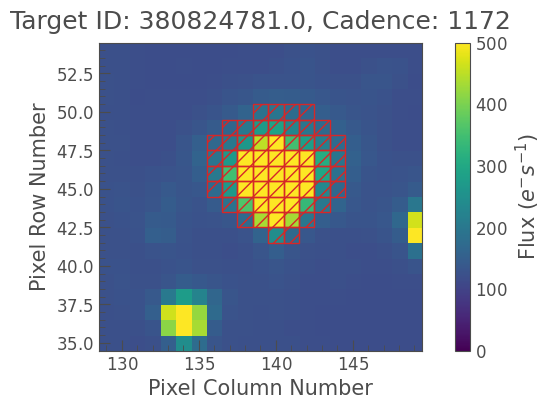

100%|██████████| 1245/1245 [00:01<00:00, 1075.21it/s]


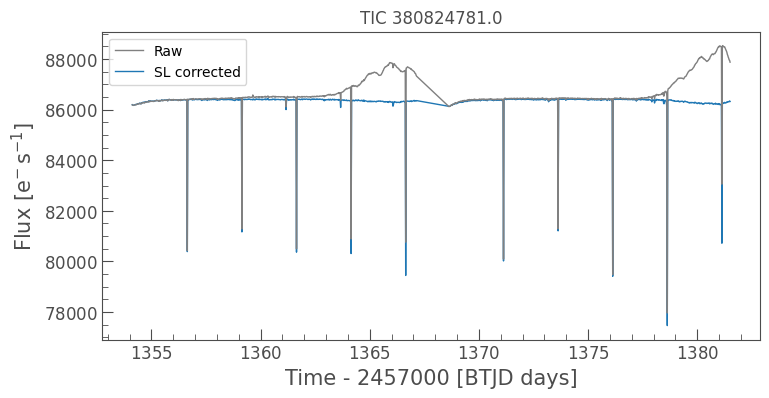

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


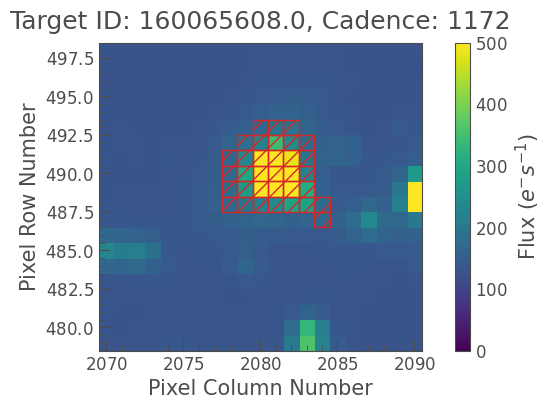

100%|██████████| 1245/1245 [00:01<00:00, 1091.25it/s]


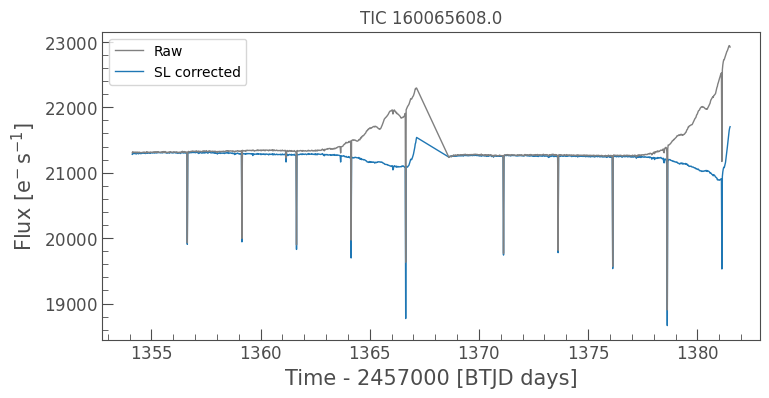

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


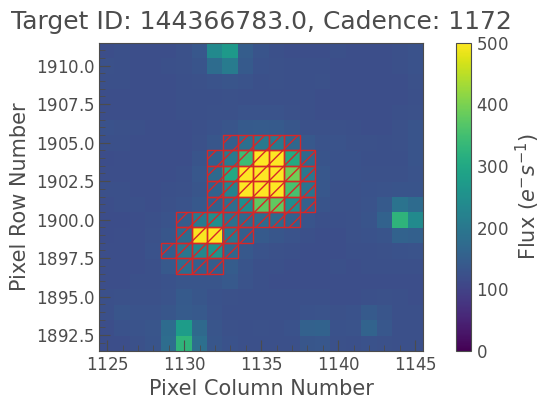

100%|██████████| 1245/1245 [00:01<00:00, 1091.30it/s]


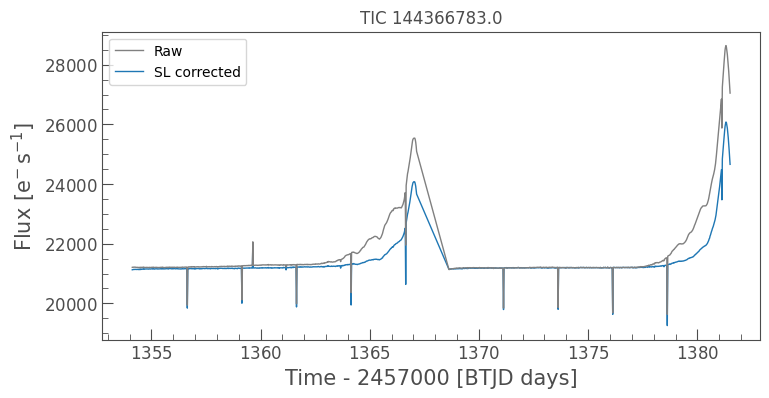

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


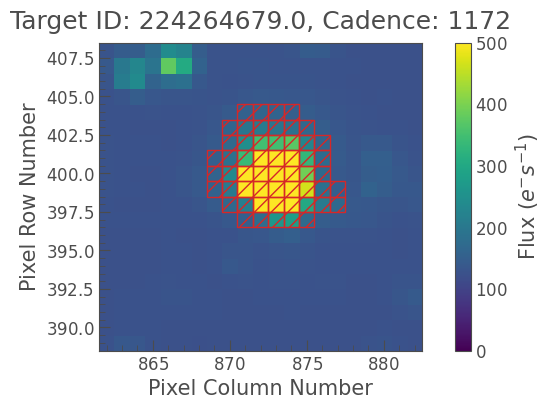

100%|██████████| 1245/1245 [00:01<00:00, 1042.94it/s]


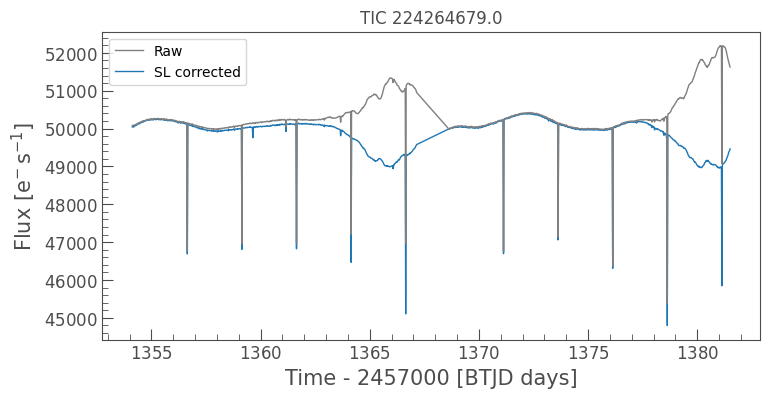

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


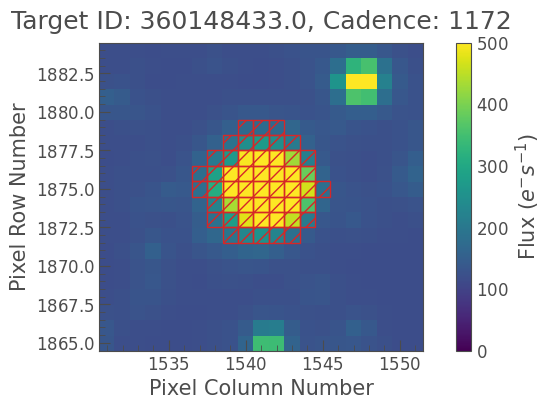

100%|██████████| 1245/1245 [00:01<00:00, 1071.20it/s]


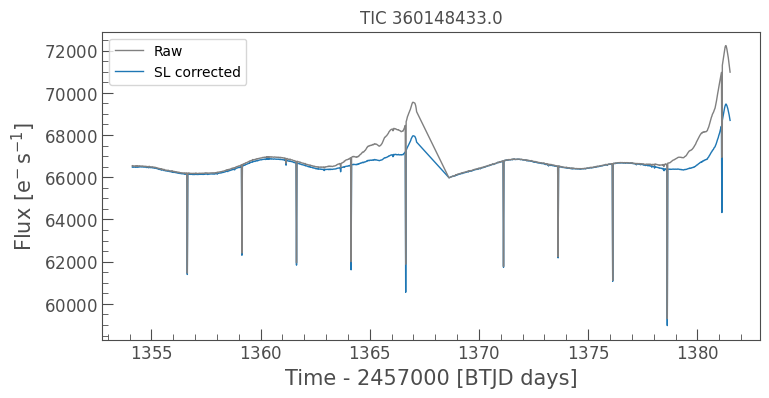

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


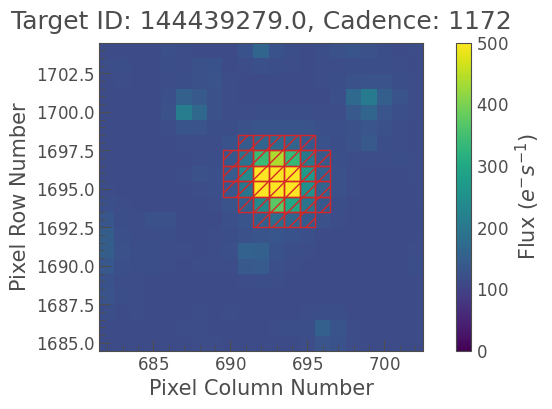

100%|██████████| 1245/1245 [00:01<00:00, 1072.45it/s]


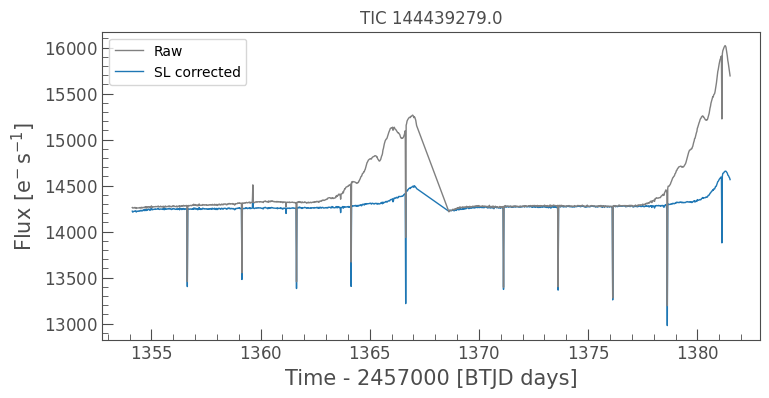

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


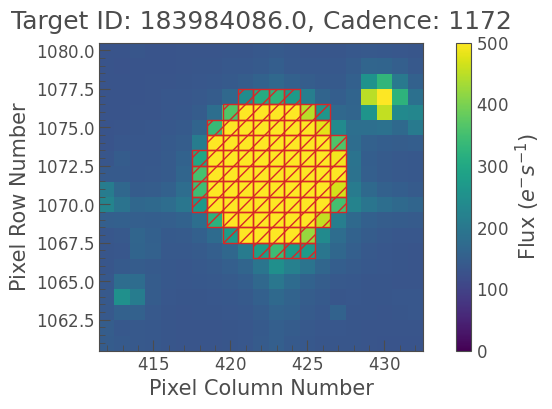

100%|██████████| 1245/1245 [00:01<00:00, 1073.75it/s]


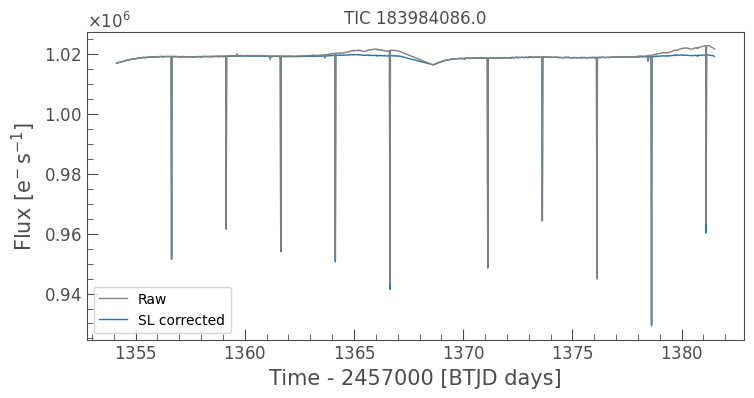

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


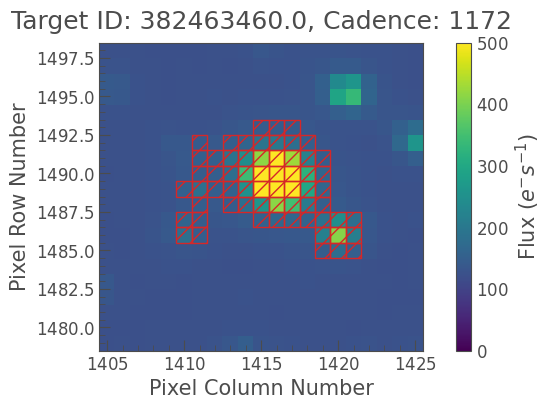

100%|██████████| 1245/1245 [00:01<00:00, 1092.09it/s]


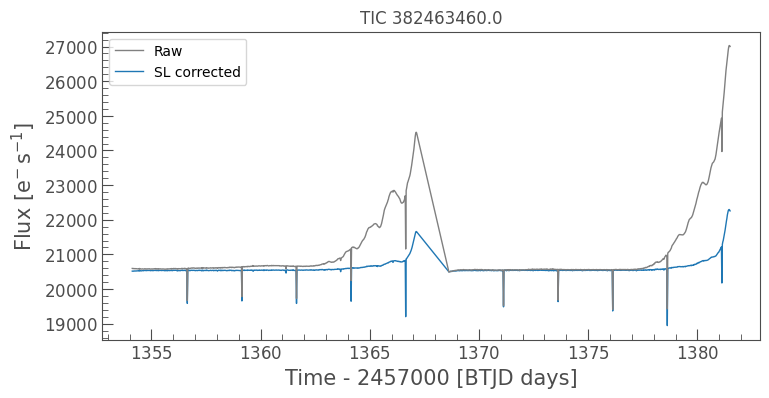

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


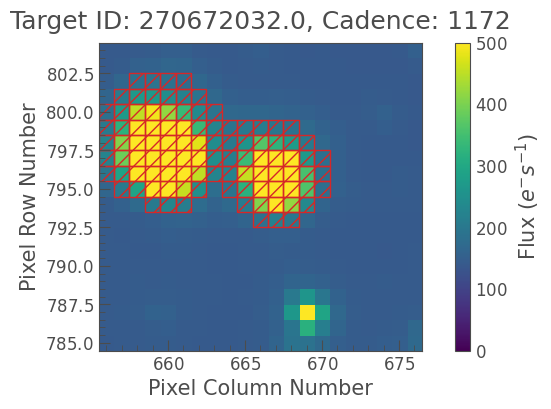

100%|██████████| 1245/1245 [00:01<00:00, 1086.97it/s]


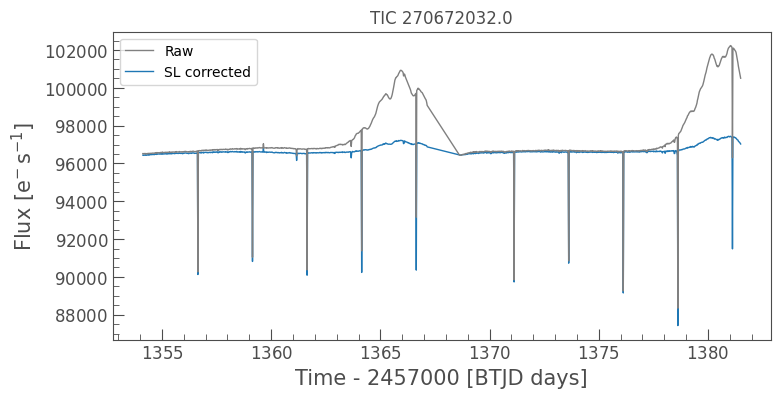

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


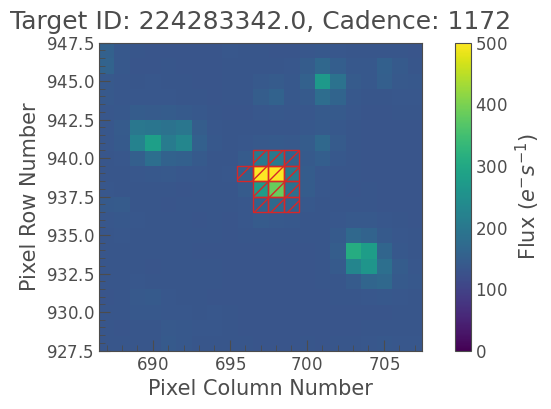

100%|██████████| 1245/1245 [00:01<00:00, 1049.80it/s]


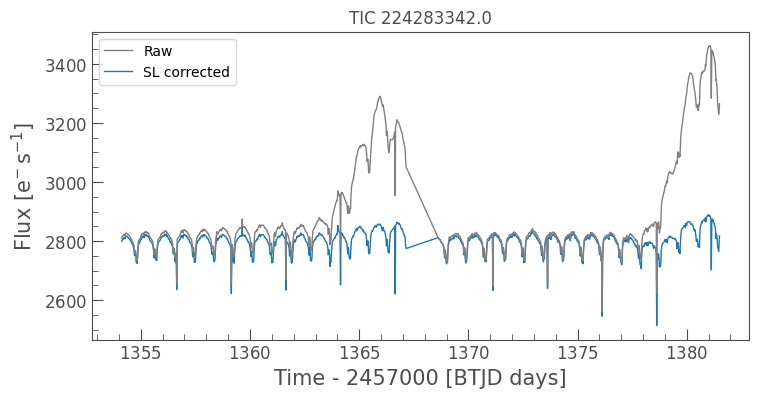

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


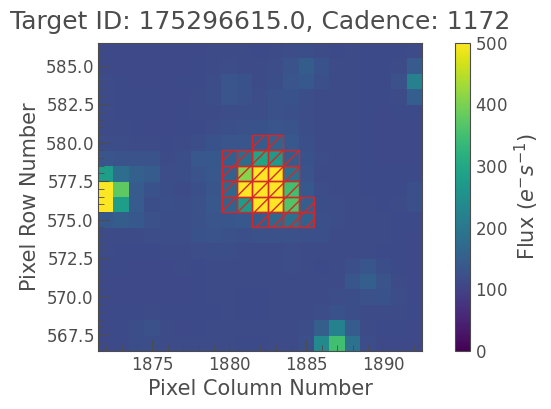

100%|██████████| 1245/1245 [00:01<00:00, 1060.78it/s]


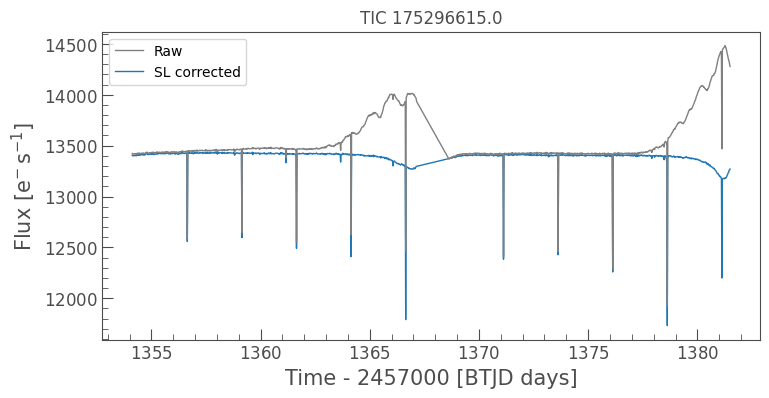

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


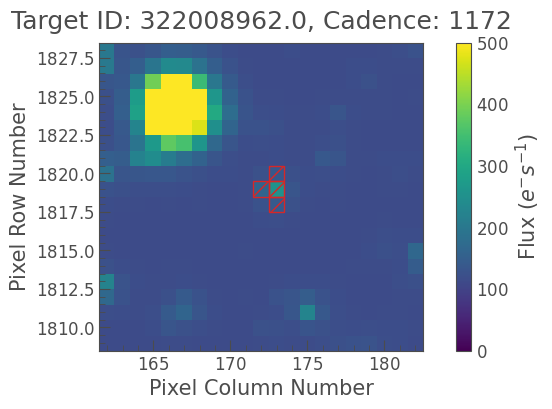

100%|██████████| 1245/1245 [00:01<00:00, 1089.49it/s]


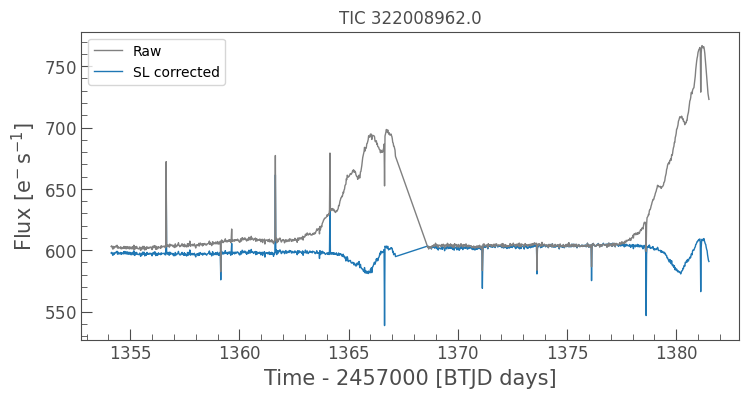

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


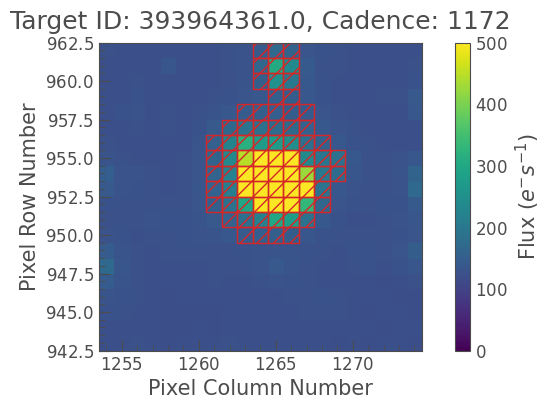

100%|██████████| 1245/1245 [00:01<00:00, 1091.68it/s]


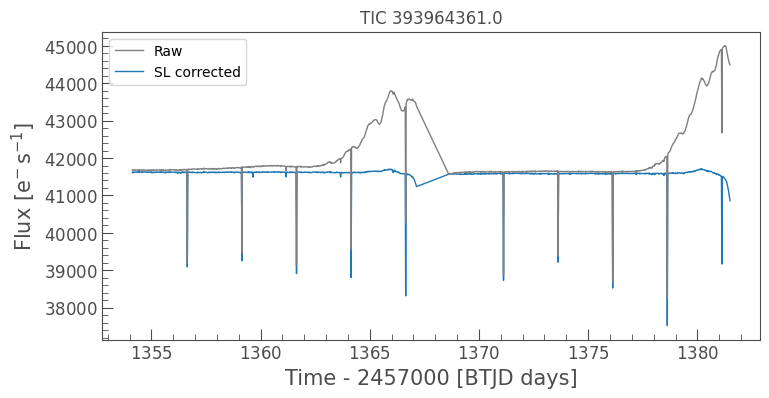

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


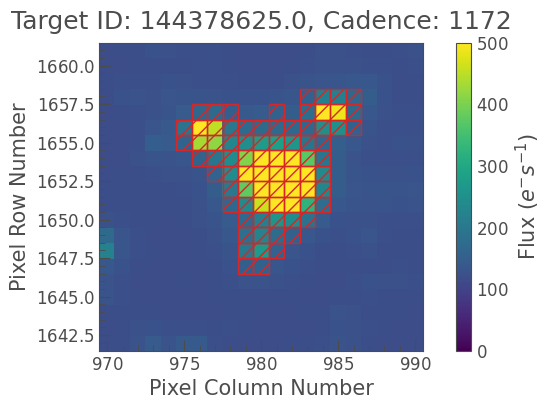

100%|██████████| 1245/1245 [00:01<00:00, 1067.18it/s]


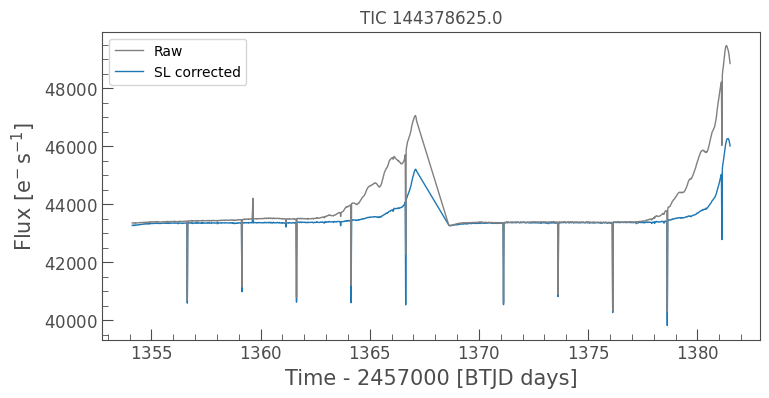

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


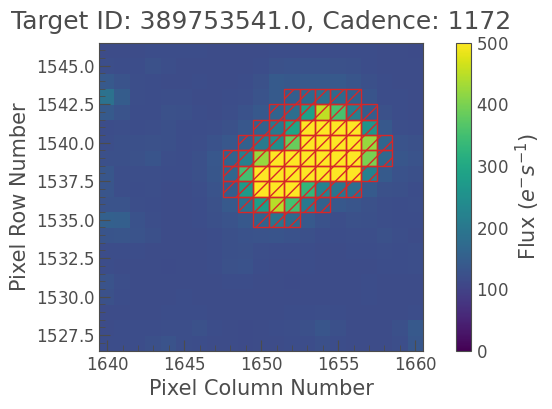

100%|██████████| 1245/1245 [00:01<00:00, 1062.18it/s]


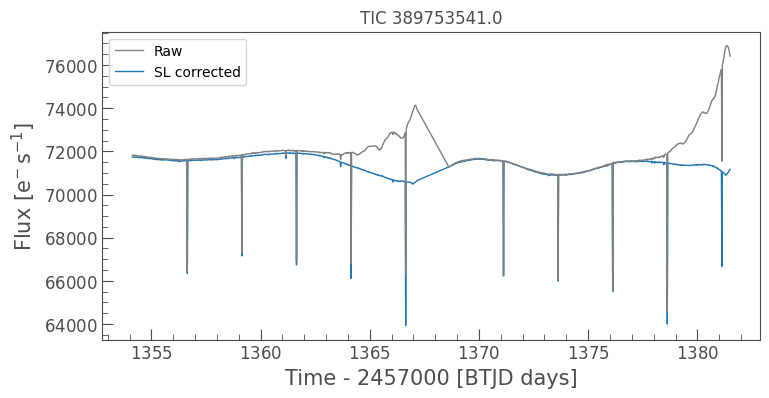

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


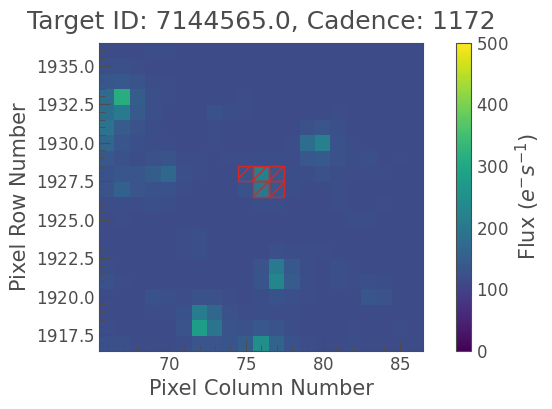

100%|██████████| 1245/1245 [00:01<00:00, 1028.90it/s]


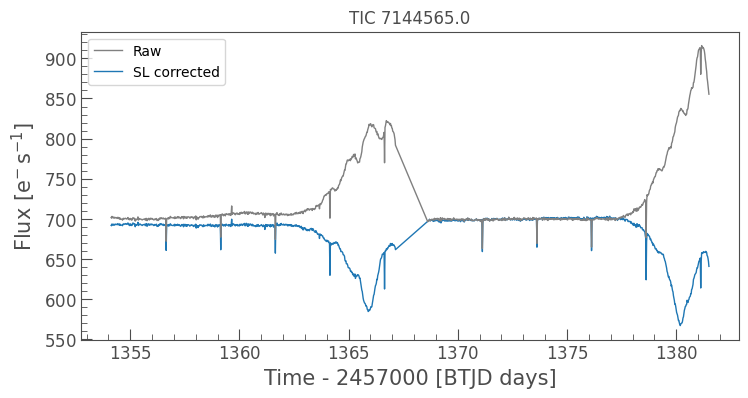

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


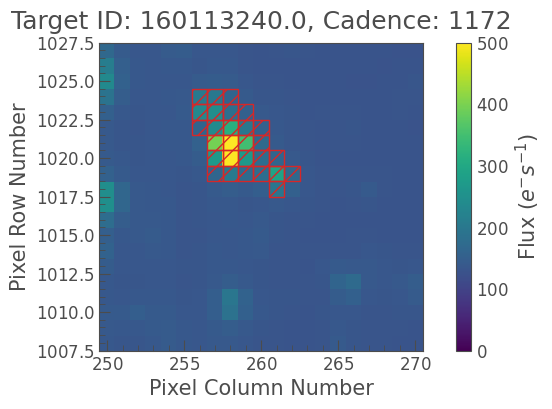

100%|██████████| 1245/1245 [00:01<00:00, 1080.90it/s]


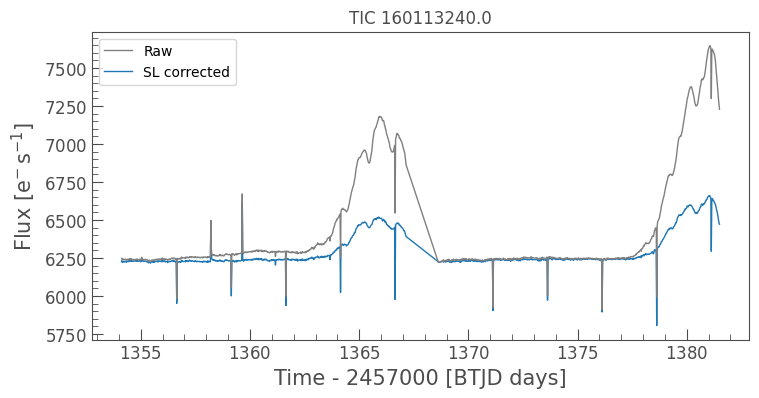

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


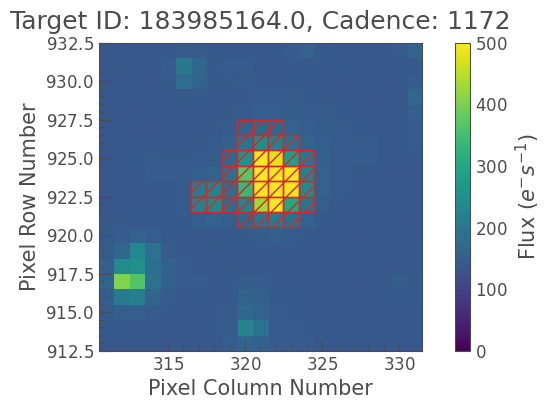

100%|██████████| 1245/1245 [00:01<00:00, 1093.70it/s]


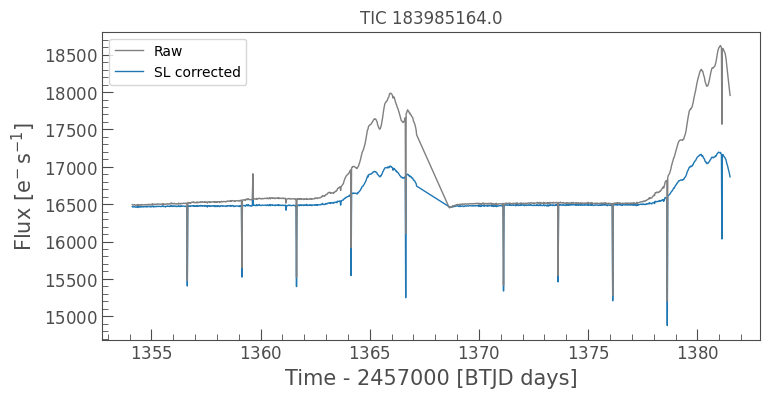

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


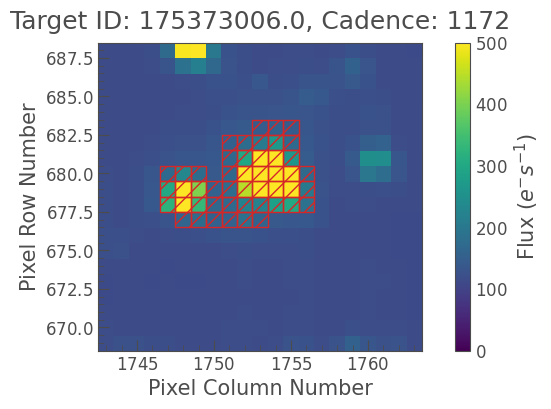

100%|██████████| 1245/1245 [00:01<00:00, 1088.73it/s]


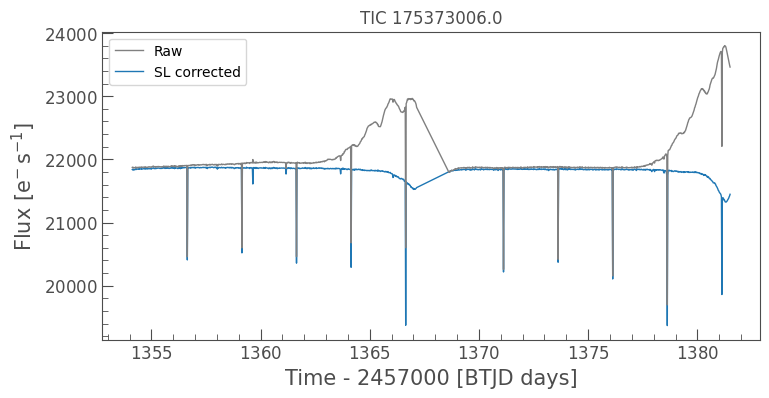

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


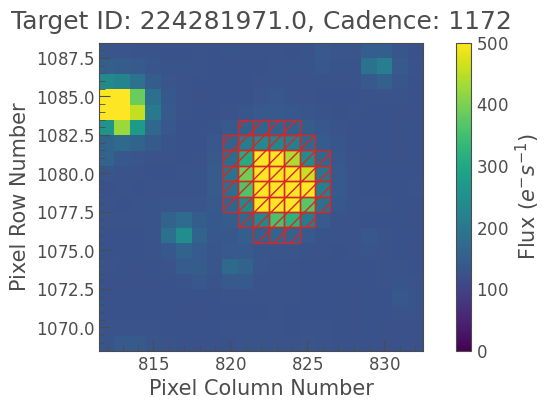

100%|██████████| 1245/1245 [00:01<00:00, 1057.03it/s]


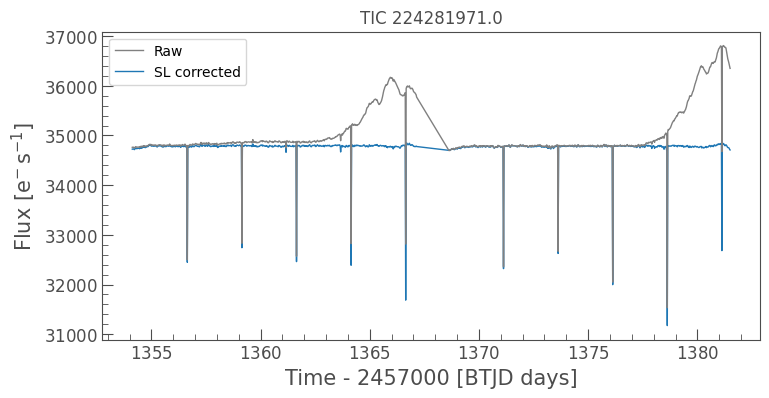

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


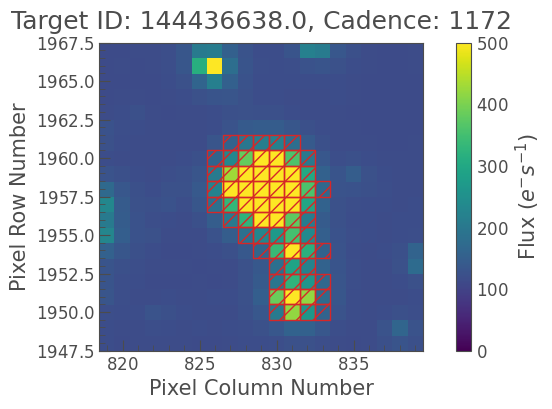

100%|██████████| 1245/1245 [00:01<00:00, 1093.03it/s]


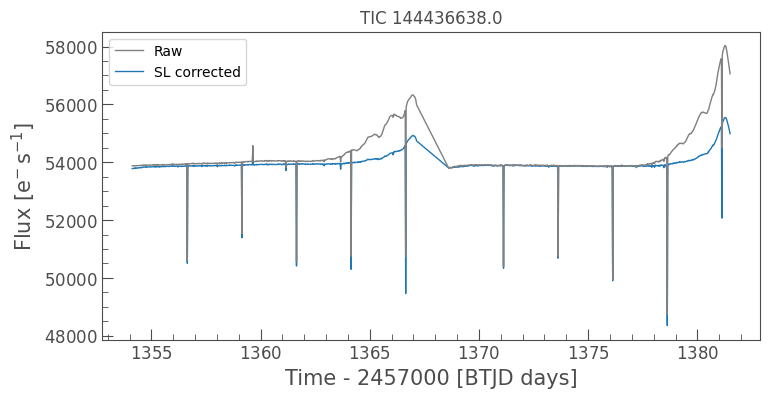

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


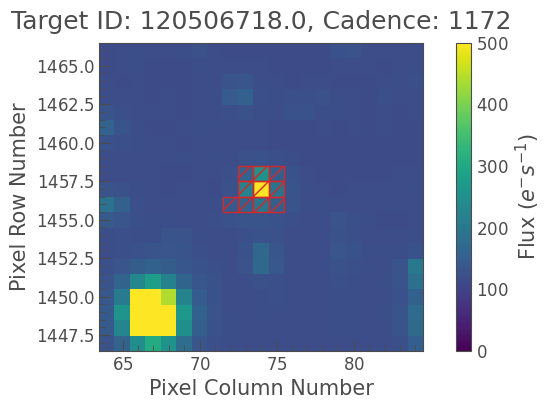

100%|██████████| 1245/1245 [00:01<00:00, 1044.05it/s]


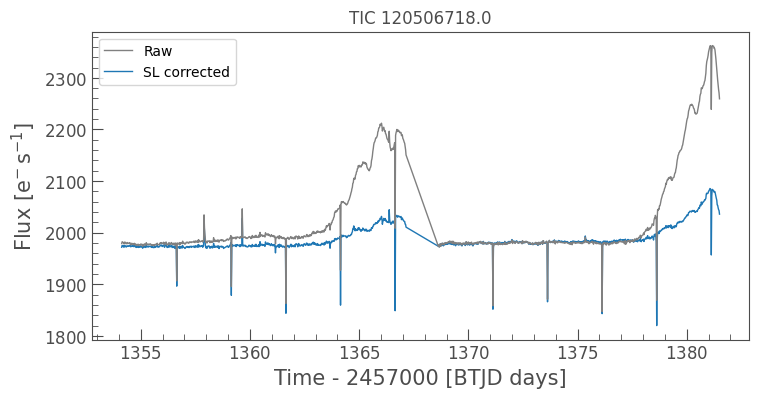

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


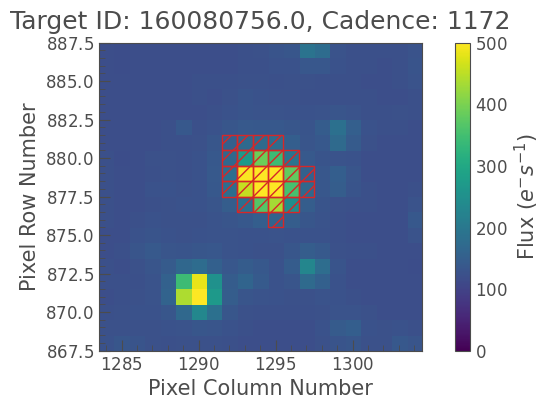

100%|██████████| 1245/1245 [00:01<00:00, 1066.40it/s]


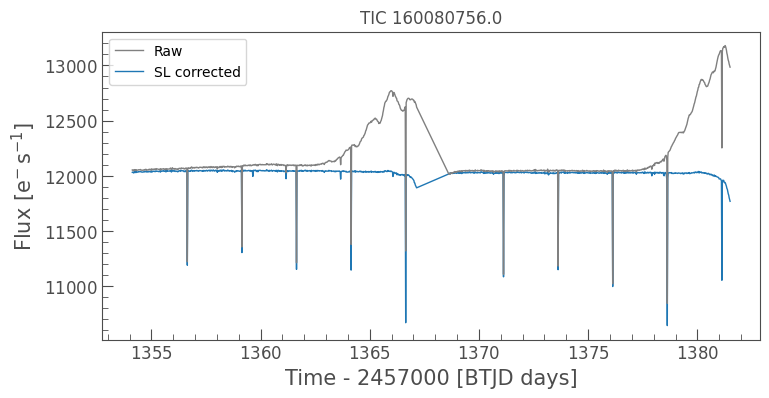

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


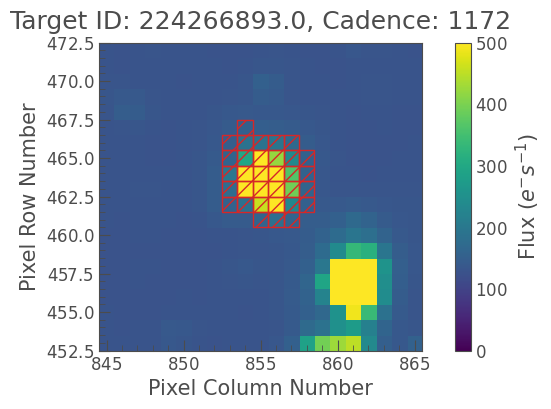

100%|██████████| 1245/1245 [00:01<00:00, 1084.81it/s]


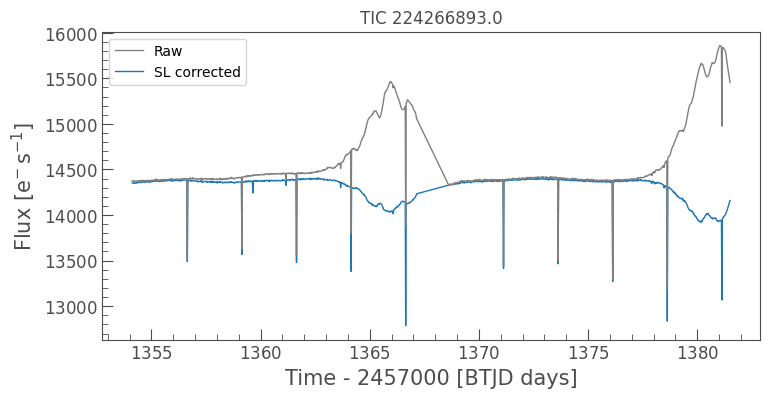

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


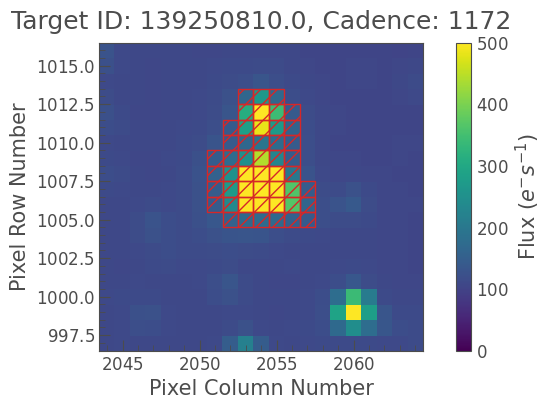

100%|██████████| 1245/1245 [00:01<00:00, 1089.85it/s]


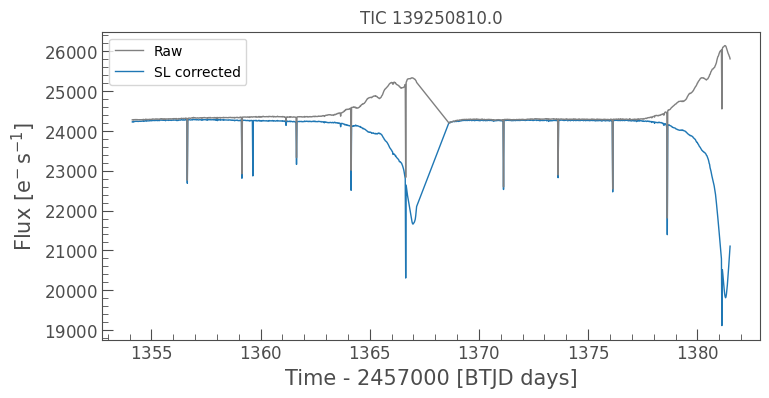

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


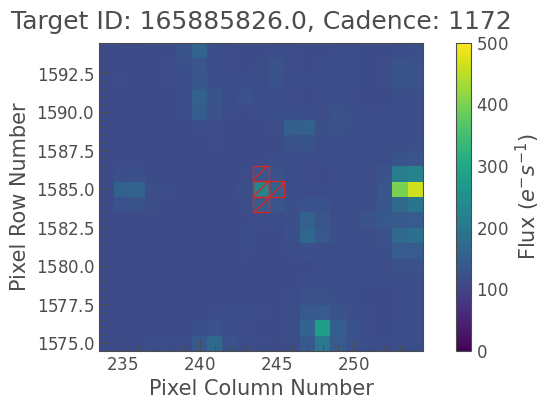

100%|██████████| 1245/1245 [00:01<00:00, 1062.59it/s]


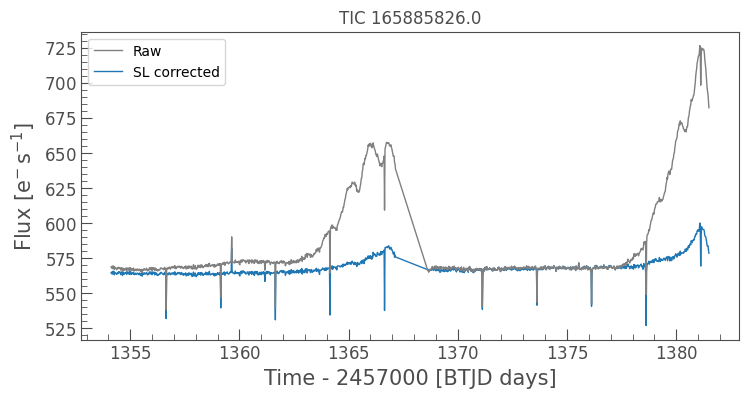

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


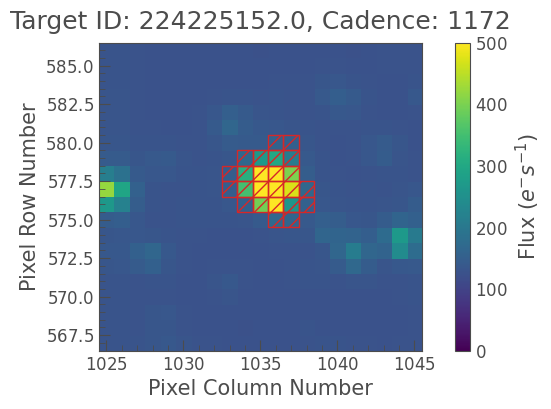

100%|██████████| 1245/1245 [00:01<00:00, 1093.27it/s]


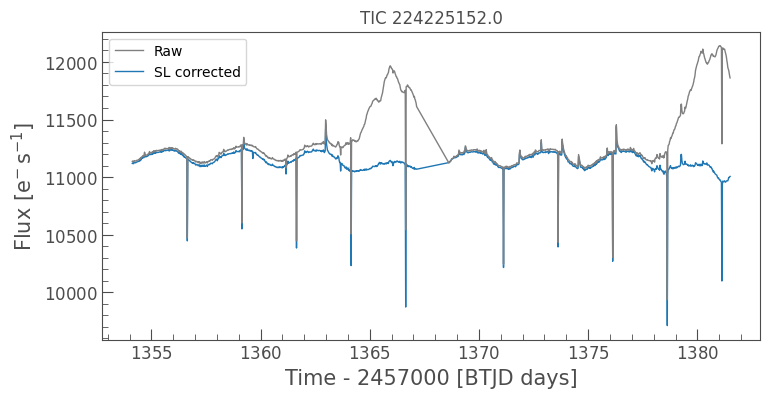

In [318]:
for k, item in tics.sample(50, replace=False).iterrows():
    
    coord = SkyCoord(ra=item.ra*u.deg, dec=item.dec*u.deg)
    fname = f"./data//tic_{item.TIC}_sector{sector}_{camera}-{ccd}.fits"
    
    tcube.get_tpf(coord).writeto(fname, overwrite=True)
    tpf = lk.read(fname, quality_bitmask="none")
    tpf.targetid = item.TIC
    
    apmask = tpf.create_threshold_mask(threshold=5)
    tpf.plot(frame=1172, aperture_mask=apmask, mask_color="tab:red", vmin=0, vmax=500);
    plt.show()
    
    scatlight = []
    
    step = 16
    row = np.arange(rmin, rmax, step)
    col = np.arange(cmin, cmax, step)
    eval_row = np.arange(tpf.row, tpf.row + tpf.shape[1])
    eval_col = np.arange(tpf.column, tpf.column + tpf.shape[2])
    
    for tdx in tqdm(range(cube_sl.shape[0])):
        interp2d = RectBivariateSpline(col, row, cube_sl[tdx])
        eval_sl = interp2d(eval_col, eval_row)
        scatlight.append(eval_sl.T)
        
    scatlight = np.array(scatlight)
    tpf.flux_corr = tpf.flux - scatlight * tpf.flux.unit
    
    lc = tpf.extract_aperture_photometry(aperture_mask=apmask)
    lc_corr = np.nansum(tpf.flux_corr[:, apmask], axis=1)
    
    ax = lc.plot(label="Raw", lw=1, c="gray")
    ax.plot(lc.time.value, lc_corr, label="SL corrected", zorder=-5000, lw=1, c="tab:blue")
    ax.set_title(f"TIC {item.TIC}")
    plt.legend()
    plt.show()

    # break